Plotting, using SVG:

In [129]:
using FFTW
using PyCall
using PyPlot
using Statistics

PyPlot.svg(true)

corner = pyimport("corner")

PyObject <module 'corner' from '/Users/wfarr/anaconda3/lib/python3.7/site-packages/corner/__init__.py'>

We discussed a simple model in class, where we have a circuit with two resistors in series, a battery, and an ammeter.  The ammeter makes a (noisy) measurement of the current $I$ flowing through the circuit; the battery is at voltage $V$; one of the resistors has been calibrated and is adjustable by us; and we want to measure the resistance, $R$ of the other resistor.  Let the setting of the adjustable resistor be $x$, and the measured current $y$; then we have 
$$
y = I + \mathrm{noise} = \frac{V}{R + x} + \mathrm{noise}.
$$

If we model the noise as a Gaussian with zero mean and unknown standard deviation, $\sigma$, then we have three parameters ($V$, $R$, $\sigma$) to measure.  We have 
$$
y = \frac{V}{R + x} + \epsilon
$$
with $\epsilon \sim N(0,\sigma)$.  Under repeated measurements (assuming statistically independent noise on each measurement) with different settings of $x$, we obtain a data set $\left( y_i, x_i \right)$ whose likelihood is 
$$
p\left( \left\{ x_i, y_i \right\} \mid V, R, \sigma \right) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi} \sigma} \exp\left[ -\frac{1}{2} \left( \frac{\frac{V}{R + x_i} - y_i}{\sigma} \right)^2 \right]
$$

Here we will construct a MCMC sampler for $V,R,\sigma$ given such a data set.  First, to generate mock data, we choose true values of the parameters:

In [2]:
Rtrue = 1000.0
Vtrue = 3.0
sigma_true = 1e-4

0.0001

Now we choose a large number of dial settings (it will be 

In [104]:
xs = exp.(collect(log(Rtrue/10):0.1:log(10*Rtrue)))
ys = Vtrue./(Rtrue .+ xs) .+ sigma_true.*randn(length(xs));

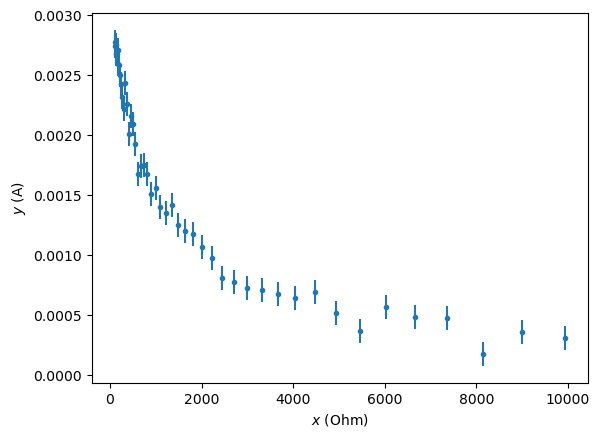

PyObject Text(28.0, 0.5, '$y$ ($\\mathrm{A}$)')

In [105]:
errorbar(xs, ys, yerr=sigma_true, fmt=".")
xlabel(L"$x$ ($\mathrm{Ohm}$)")
ylabel(L"$y$ ($\mathrm{A}$)")

In [5]:
function next_mcmc_state(theta, proposal, log_proposal_density, log_prob)
    theta_prime = proposal(theta)
    log_post_ratio = log_prob(theta_prime) - log_prob(theta)
    log_prop_ratio = log_proposal_density(theta, theta_prime) - log_proposal_density(theta_prime, theta)
    log_paccept = log_post_ratio + log_prop_ratio
    if log(rand()) < log_paccept
        theta_prime
    else
        theta
    end
end

next_mcmc_state (generic function with 1 method)

In [87]:
function log_prob_unit_normal(x)
    return -0.5*x*x
end
function proposal_unit_normal(x)
    x + 0.001*randn()
end
function log_proposal_density_unit_normal(x, y)
    zero(x)
end

log_proposal_density_unit_normal (generic function with 1 method)

In [88]:
xs = [0.0]
for i in 1:10000
    push!(xs, next_mcmc_state(xs[end], proposal_unit_normal, log_proposal_density_unit_normal, log_prob_unit_normal))
end

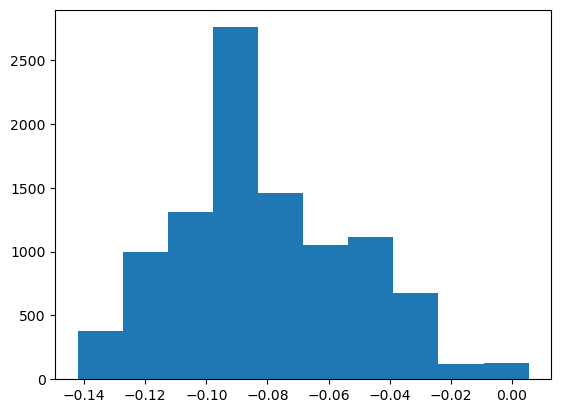

([379.0, 999.0, 1313.0, 2758.0, 1457.0, 1056.0, 1111.0, 679.0, 122.0, 127.0], [-0.1420901076419613, -0.12733264886841697, -0.11257519009487264, -0.0978177313213283, -0.08306027254778398, -0.06830281377423963, -0.053545355000695294, -0.03878789622715097, -0.024030437453606626, -0.0092729786800623, 0.005484480093482042], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x1432ffbe0>, PyObject <matplotlib.patches.Rectangle object at 0x143787f28>, PyObject <matplotlib.patches.Rectangle object at 0x1432fff98>, PyObject <matplotlib.patches.Rectangle object at 0x1433094a8>, PyObject <matplotlib.patches.Rectangle object at 0x1433097b8>, PyObject <matplotlib.patches.Rectangle object at 0x143309ac8>, PyObject <matplotlib.patches.Rectangle object at 0x143309dd8>, PyObject <matplotlib.patches.Rectangle object at 0x143309ef0>, PyObject <matplotlib.patches.Rectangle object at 0x143315438>, PyObject <matplotlib.patches.Rectangle object at 0x143315748>])

In [89]:
hist(xs)

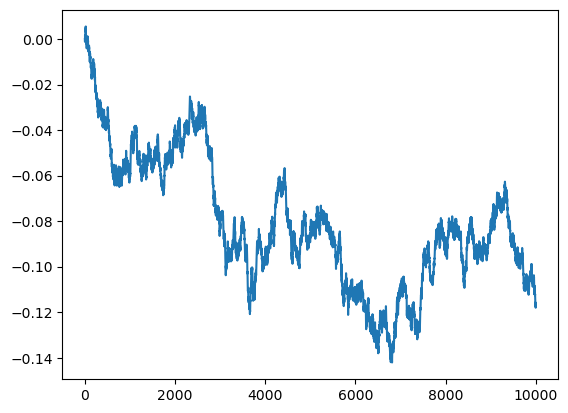

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x143dcde10>

In [90]:
plot(xs)

In [91]:
mean(xs), std(xs), 1/sqrt(10000/40)

(-0.08128034924530382, 0.028869481644272835, 0.06324555320336758)

In [92]:
function next_pow_two(n)
    i = 1
    while i < n
        i = i*2
    end
    return i
end

function autocorrelation_function(xs)
    xs = xs .- mean(xs)
    n = size(xs,1)
    N = next_pow_two(2*n)
    xs_ext = zeros(N)
    xs_ext[1:n] = xs
    ys = rfft(xs_ext)
    ys = ys.*conj(ys)
    acf = irfft(ys, N)
    acf = acf ./ acf[1]
    acf[1:n]
end

autocorrelation_function (generic function with 1 method)

In [93]:
acf = autocorrelation_function(xs)

10001-element Array{Float64,1}:
  1.0                  
  0.9989309403792666   
  0.9978793422200063   
  0.9968215151679745   
  0.9957374466977178   
  0.9946584291891996   
  0.9935878643851848   
  0.9925165871655315   
  0.9914387916605089   
  0.9903473200429395   
  0.9892771034999757   
  0.9882023498775644   
  0.9870829008482174   
  ⋮                    
 -0.004202633980290918 
 -0.003840615030142989 
 -0.003488419483356083 
 -0.0031400032061431314
 -0.002785176971071167 
 -0.0024498502935947305
 -0.002102513589307468 
 -0.0017461681149967157
 -0.0013988194498530558
 -0.0010334045089181363
 -0.0006854869030819995
 -0.0003467274406562062

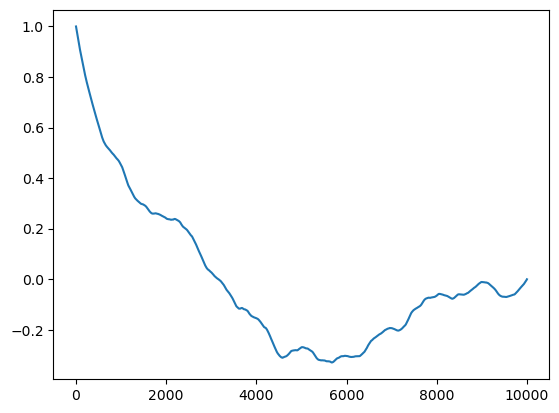

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x143e32400>

In [94]:
plot(acf)

In [95]:
sum(2 .* acf[1:1000]) - 1

1298.149037459902

In [96]:
function acl_estimate(xs)
    acf = autocorrelation_function(xs)
    
    sums = 0.0
    acl_est = 0.0
    for i in 1:size(xs, 1)
        sums = sums + acf[i]
        acl_est = 2.0*sums - 1.0
        if i > 5*acl_est && i > 1
            break
        end
    end
    
    if acl_est > 0.2*size(xs,1)
        return Inf
    else
        return acl_est
    end
end

acl_estimate (generic function with 1 method)

In [97]:
acl_estimate(xs)

1143.9067524824025

In [110]:
"""Returns a log-probability function given an array of observed currents."""
function make_log_prob(x, Iobs)
    Nobs = size(Iobs, 1)
    function lnprob(theta)
        V, R, sigma = theta
        
        if V < 0
            return -Inf
        end
        if R < 0
            return -Inf
        end
        if sigma < 0
            return -Inf
        end
        
        return -0.5*Nobs*log(2*pi)-Nobs*log(sigma) - 0.5*sum(((Iobs .- V./(R .+ x))/sigma).^2)
    end
end

make_log_prob

In [111]:
log_prob = make_log_prob(xs, ys)

(::getfield(Main, Symbol("#lnprob#4")){Array{Float64,1},Array{Float64,1},Int64}) (generic function with 1 method)

In [123]:
function circuit_fit_proposal(theta)
    V, R, sigma = theta
    
    return [V + 0.01*randn(), R+10*randn(), sigma+1e-5*randn()]
end

circuit_fit_proposal (generic function with 1 method)

In [124]:
function circuit_fit_log_prop_density(theta, theta_new)
    return 0.0
end

circuit_fit_log_prop_density (generic function with 2 methods)

In [125]:
thetas = [[1.0, 1000.0, 1e-3]]
for i in 1:10000
    push!(thetas, next_mcmc_state(thetas[end], circuit_fit_proposal, circuit_fit_log_prop_density, log_prob))
end

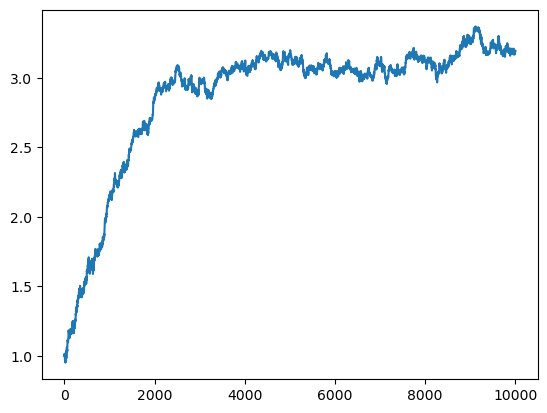

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x143f5ab00>

In [126]:
plot([t[1] for t in thetas])

In [127]:
thetas = [thetas[end]]
for i in 1:10000
    push!(thetas, next_mcmc_state(thetas[end], circuit_fit_proposal, circuit_fit_log_prop_density, log_prob))
end

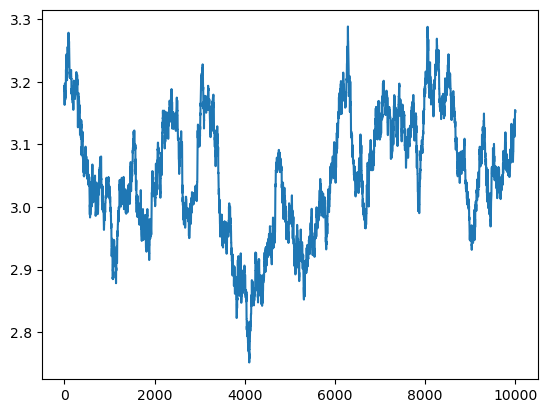

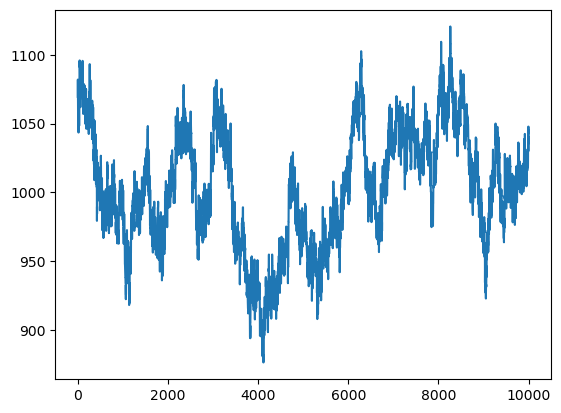

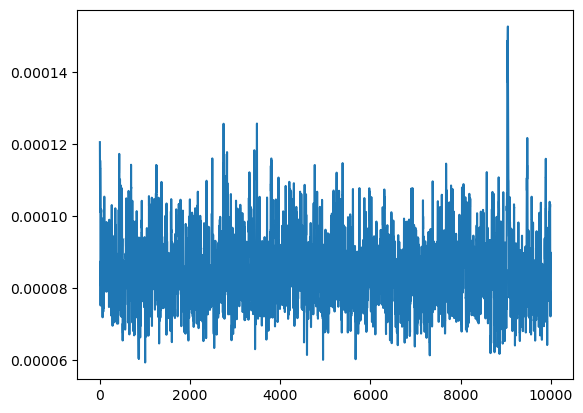

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14965a3c8>

In [128]:
plot([t[1] for t in thetas])
figure()
plot([t[2] for t in thetas])
figure()
plot([t[3] for t in thetas])

In [131]:
samples = hcat(thetas...)'

10001×3 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 3.19298  1069.46  0.000120441
 3.1846   1082.01  0.0001153  
 3.1846   1082.01  0.0001153  
 3.17124  1073.15  0.000107514
 3.16308  1073.96  0.000101145
 3.16308  1073.96  0.000101145
 3.1769   1064.39  0.00011535 
 3.19449  1049.11  0.000113085
 3.19449  1049.11  0.000113085
 3.19449  1049.11  0.000113085
 3.19449  1049.11  0.000113085
 3.18395  1048.43  0.000108767
 3.19744  1063.29  0.00010557 
 ⋮                            
 3.12129  1035.34  7.92088e-5 
 3.12819  1045.64  7.79196e-5 
 3.12819  1045.64  7.79196e-5 
 3.15013  1042.51  7.20566e-5 
 3.15013  1042.51  7.20566e-5 
 3.15466  1047.85  7.62921e-5 
 3.15212  1035.49  7.59323e-5 
 3.15043  1040.65  8.0793e-5  
 3.15043  1040.65  8.0793e-5  
 3.15352  1030.53  8.96867e-5 
 3.15352  1030.53  8.96867e-5 
 3.15352  1030.53  8.96867e-5 

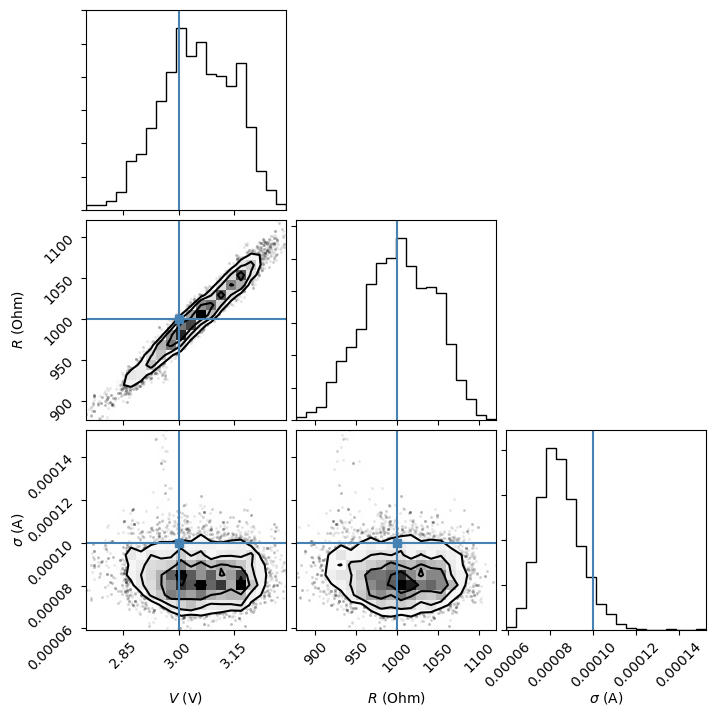

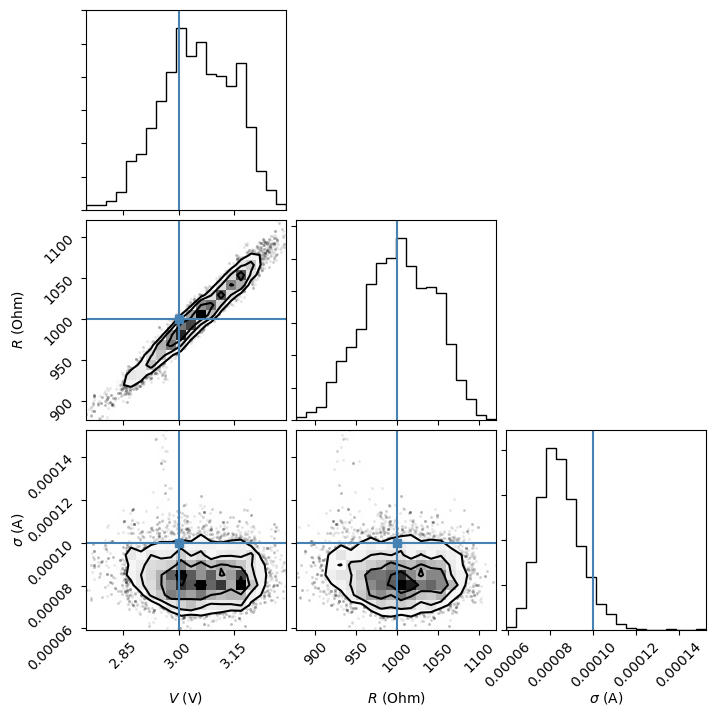

In [135]:
corner.corner(samples, 
    truths=[Vtrue, Rtrue, sigma_true], 
    labels=[L"$V$ ($\mathrm{V}$)",
            L"$R$ ($\mathrm{Ohm}$)",
            L"$\sigma$ ($\mathrm{A}$)"])

In [137]:
size(samples)

(10001, 3)

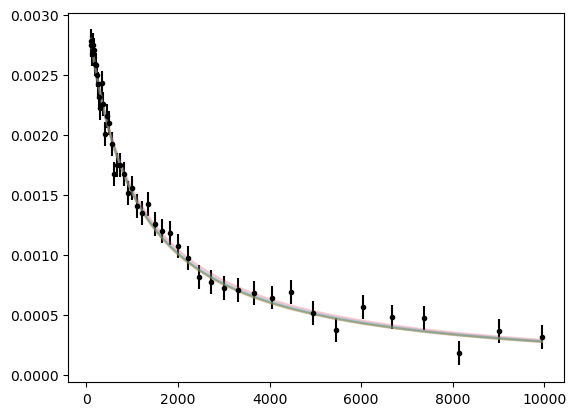

In [138]:
errorbar(xs, ys, yerr=sigma_true, fmt=".", color="k")
for i in 1:10
    j = rand(1:size(samples,1))
    V, R, sigma = samples[j,:]
    plot(xs, V./(R.+xs), alpha=0.2)
end

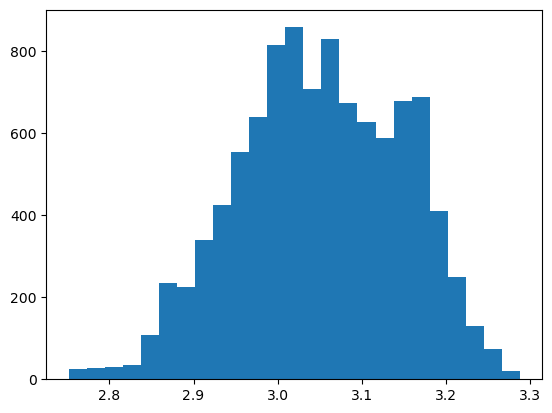

(3.0508848243872864, 0.09755706806723084)

In [142]:
hist(samples[:,1], bins=25)
mean(samples[:,1]), std(samples[:,1])